# Synthetic Control

In this tutorial, we are going to see how to estimate causal effects when the treatment is not randomly assigned, we have acces to a control group and we observe few units but potentially many time periods. These settings are extremely common in observational studies and, in these cases, claims of causality are relatively weak. However, there still exist methods for causal inference, under certain assumptions.

**Requisites**

For this tutorial, I assume you are familiar with the following concepts:

- Rubin's potential outcome framework
- Ordinary least squares regression
- [Randomization/permutation inference](https://matteocourthoud.github.io/post/permutation_test/)
- [Difference in differences](https://matteocourthoud.github.io/post/diff_in_diffs/)

**Academic Application**

As an academic application, we are going to replicate [Synthetic Control Methods for Comparative Case Studies: Estimating the Effect of California’s Tobacco Control Program](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) (2010) by Abadie, Diamond and Hainmueller. The authors study the effect of a tobacco control program in California on smoking habits.

**Business Case**

TBD

## Setting

We assume that for a panel of i.i.d. subjects $i = 1, ..., n$ over time $t=1, ...,T$ we observed a tuple $(X_{it}, Y_{it})$ comprised of 

- a feature vector $X_{i,t} \in \mathbb R^p$
- a treatment assignment $D_i \in \lbrace 0, 1 \rbrace$
- a response $Y_{i,t} \in \mathbb R$

Moreover, one unit is treated at time $t^*$. We distinguish time periods before treatment and time periods after treatment.

Crucially, treatment $D_i$ is not randomly assignment, therefore a difference in means between the treated unit(s) and the control group is not an unbiased estimator of the average treatment effect.

## Synthetic Control

The problem is that, as usual, we do not observe the counterfactual outcome for treated units, i.e. we do not know what would have happened to them, if they had not been treated. This is known as the **fundamental problem of causal inference**.

The simplest approach, would be just to compare pre and post periods. This is called the **event study** approach.

However, we can do better than this. In fact, even though treatment was not randomly assigned, we still have access to some units that were not treated.

For the outcome variable we have the following setup

$$
Y = 
\begin{bmatrix}
Y_{t, post} \ & Y_{c, post} \newline 
Y_{t, pre} \ & Y_{c, pre} 
\end{bmatrix}
$$

which we can rewrite as 

$$
Y = 
\begin{bmatrix}
Y^{(1)} _ {t, post} \ & Y^{(0)} _ {c, post} \newline 
Y^{(0)} _ {t, pre} \ & Y^{(0)} _ {c, pre} 
\end{bmatrix}
$$

We basically have a **missing data problem** since we do not observe $Y^{(0)} _ {t, post}$.

Following Doudchenko and Inbens (2018), we can formulate an estimate of the counterfactual outcome for the treated unit as a linear combination of the observed outcomes for the control units.

$$
\hat Y^{(0)} _ {t, post} = \alpha + \sum_{i \in c} \beta_{i} Y^{(0)} _ {i, post}
$$

where

- the constant $\alpha$ allows for different averages between the two groups
- the weights $\beta_i$ are allowed to vary across control units $i$ 
    - otherwise it would be a diff-in-diff

### Weights

How should we choose which weights to use? One **option** could be to simply run a linear regression of the pre-treatment outcome of the treatment unit $Y^{(0)} _ {t, pre}$ on the pre-treatment outcome of the control group $Y^{(0)} _ {c, pre}$. 

There are two problems with this approach:

1. the weights might be negative
    - how should we interpret them?
    - they make no sense in the potential outcome framework
    
2. weights could be greater or lower than one
    - therefore we would not be able to interpret the synthetic control as a weighted average of untreated units
   
To solve this problem, Abadie et al. (2010) propose the following weights:

$$
\hat \beta = \arg \min_{\beta} || \boldsymbol X_t - \boldsymbol \beta \boldsymbol X_c || = \sqrt{ \sum_{p} \left( X_{t, p}  - \sum_{i \in c} \beta_{p} X_{c, p} \right)^2 }
\quad \text{s.t.} \quad \sum_{p} \beta_p = 1 \quad \text{and} \quad \beta_p \geq 0 \ \forall p
$$

With this approach we get an interpretable counterfactual as a weighted avarage of untreated units.

### Synthetic Control vs OLS

What are the advantages and disadvantages of synthetic control methods with respect to a simple regression?

1. As long as we use positive weights that are constrained to sum to one, the method avoid extrapolation
    - we will never go out of the support of the data
    
2. It can be "pre-registered" in the sense that you don't need post-treatment observations to build the method
    - could avoid p-hacking and cherry picking
    
3. Weights make explicit the counterfactual analysis
    - one can look at the weights and understand which comparison we are making
    
4. It's a bridge between quantitative and qualitative research
    - can be used to inspect single-treated unit cases

## Academic Application

As an academic application, we are going to replicate [Synthetic Control Methods for Comparative Case Studies: Estimating the Effect of California’s Tobacco Control Program](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) (2010) by Abadie, Diamond and Hainmueller. The authors study the effect of a tobacco control program in California on smoking habits. 

This is how the authors describe the policy:

> Its primary effect is to impose a 25-cent per pack state excise tax on the sale of tobacco cigarettes within California, with approximately equivalent excise taxes similarly imposed on the retail sale of other commercial tobacco products, such as cigars and chewing tobacco. Additional restrictions placed on the sale of tobacco include a ban on cigarette vending machines in public areas accessible by juveniles, and a ban on the individual sale of single cigarettes. Revenue generated by the act was earmarked for various environmental and health care programs, and anti-tobacco advertisements.

Let's start by loading the data. We have information on cigarette costs, sales, tax rate and revenues for all US states for years from 1970 to 2014. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *

In [3]:
df = pd.read_csv('data/adh10.csv')
df.head()

,state,year,cig_sales,lnincome,beer,age15to24,retprice,california,after_treatment
0,Alabama,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,Alabama,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,Alabama,1972,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,Alabama,1973,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,Alabama,1974,108.199997,9.537163,NaN,0.183126,43.099998,False,False


Is the sample balanced? Let's check the distribution of covariates, by treatment assignment.

In [4]:
from causalml.match import create_table_one

create_table_one(df, 'california', ['cig_sales', 'lnincome', 'beer', 'age15to24', 'retprice'])

,Control,Treatment,SMD
Variable,,,
n,1178,31,
age15to24,0.18 (0.02),0.18 (0.01),0.0454
beer,23.46 (4.26),22.26 (2.11),-0.3559
cig_sales,119.53 (32.60),94.59 (30.01),-0.7962
lnincome,9.86 (0.17),10.07 (0.08),1.6107
retprice,108.04 (64.00),119.92 (77.90),0.1667


The sample is quite unbalanced. In particular, California is a richer state with a higher income, `lnincome`.

We are interested in the sales of cigarettes `cig_sales` over time. Let's start by reshaping the dataset so that each state is a time series.

In [5]:
df = df.pivot(index='year', columns='state', values='cig_sales').reset_index()
df.head()

state,year,Alabama,Arkansas,California,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,...,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming
0,1970,89.800003,100.300003,123.000000,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,...,103.599998,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997
1,1971,95.400002,104.099998,121.000000,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,...,115.000000,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997
2,1972,101.099998,103.900002,123.500000,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,...,118.699997,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000
3,1973,102.900002,108.000000,124.400002,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,...,125.500000,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997
4,1974,108.199997,109.699997,126.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,...,129.699997,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003


In an ideal world, one could use the average of all the other states in the United States as a control group for California. Let's plot the average cigarette consumption over time.

In [6]:
states = [c for c in df.columns if c not in ['year']]
df['Other States'] = df[[s for s in states if s != 'California']].mean(axis=1)

In [7]:
def plot_lines(df, line1, line2, hline=True):
    sns.lineplot(x=df['year'], y=df[line1].values, label=line1)
    sns.lineplot(x=df['year'], y=df[line2].values, label=line2)
    plt.axvline(x=1988, ls=":", color='C2', label='Proposition 99', zorder=1)
    plt.legend();
    plt.title("Per-capita cigarette sales (in packs)");

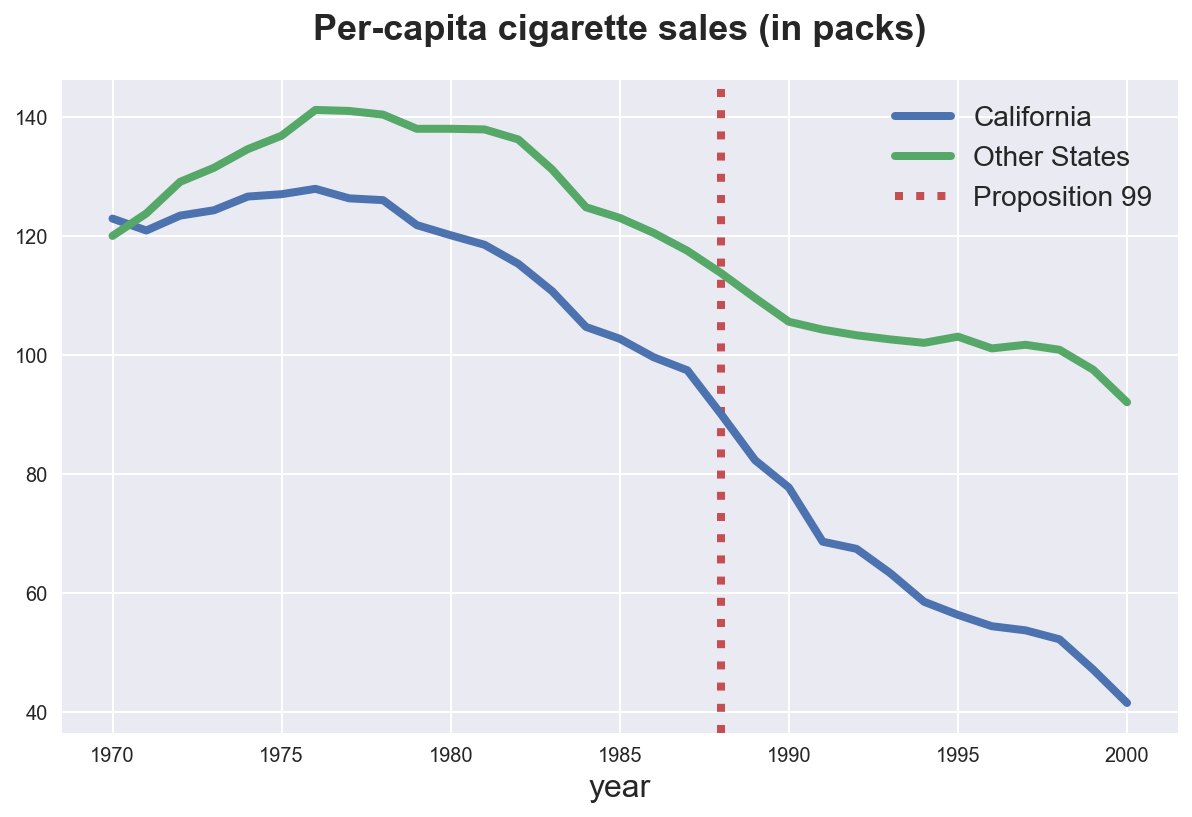

In [8]:
plot_lines(df, 'California', 'Other States')

People in California on average smoke less than in other states. This would not be a problem in a diff-in-diff setting if

- we had enough observations in each group
- trends were parallel
- other diff-in-diff assumptions were holding

However, we have just one treated unit and very few control units. Morover, the trends were definitely not parallel before treatment. Therefore, it feels quite a stretch to attribute the differences in cigarette sales post 1989 to Proposition 99 alone.

The idea is to exploit the time dimension and **build a synthetic control** state for California. Maybe no single state is a good control, but a combination of them could actually provide a good approximation to California. Moreover, we can exploit the time dimension to compensate for the fact that we have few observations. We are going to try to match the sales of cigarettes in california for all the pre-treatment years, from 1970 to 1988.

Let's start by using `LinearRegression` of `cigsales` in California onto `cigsales` of all the other states, pre 1989.

In [9]:
from sklearn.linear_model import LinearRegression

def synth_predict(df, state, model):
    y = df.loc[df['year'] <= 1988, state]
    other_states = [c for c in states if c not in ['year', state]]
    X = df.loc[df['year'] <= 1988, other_states]
    df[f'Synthetic {state}'] = model.fit(X, y).predict(df[other_states])
    return model

In [10]:
coef = synth_predict(df, 'California', LinearRegression()).coef_

How well did we predict pre-1989 sales of cigarettes in California? If we believe that that's a sensible control, what is the treatment effect?

We can visually answe both questions by plotting the actual sales of cigarettes in California against the predicted ones.

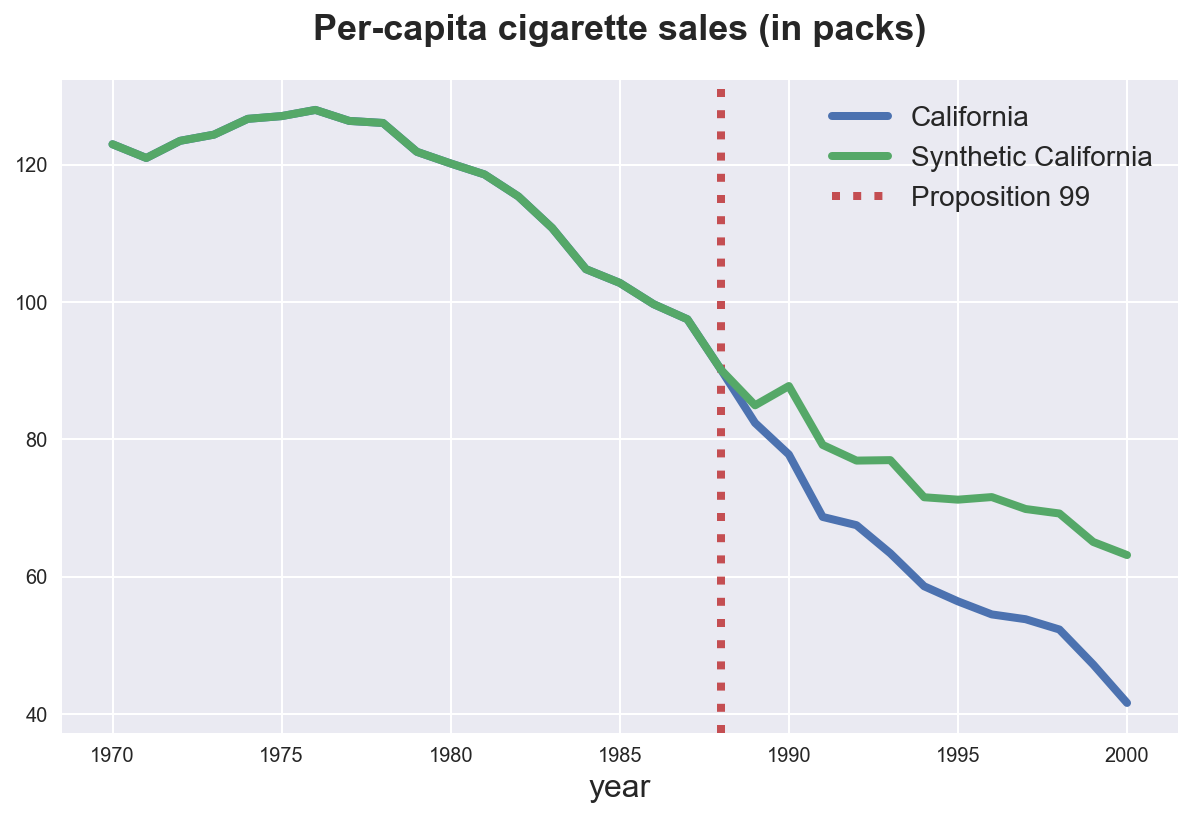

In [11]:
plot_lines(df, 'California', 'Synthetic California')

It looks like the policy had a sensible **negative effect** on cigarette sales: the predicted trend is higher than the actual sales and diverges right after the approval of Proposition 99.

We can also observe that we are clearly **overfitting**: the pre-policy predicted cigarette sales line is perfectly overlapping with the actual data. 

Another problem concerns the **weights**. We have not set any constraint on the weights. 

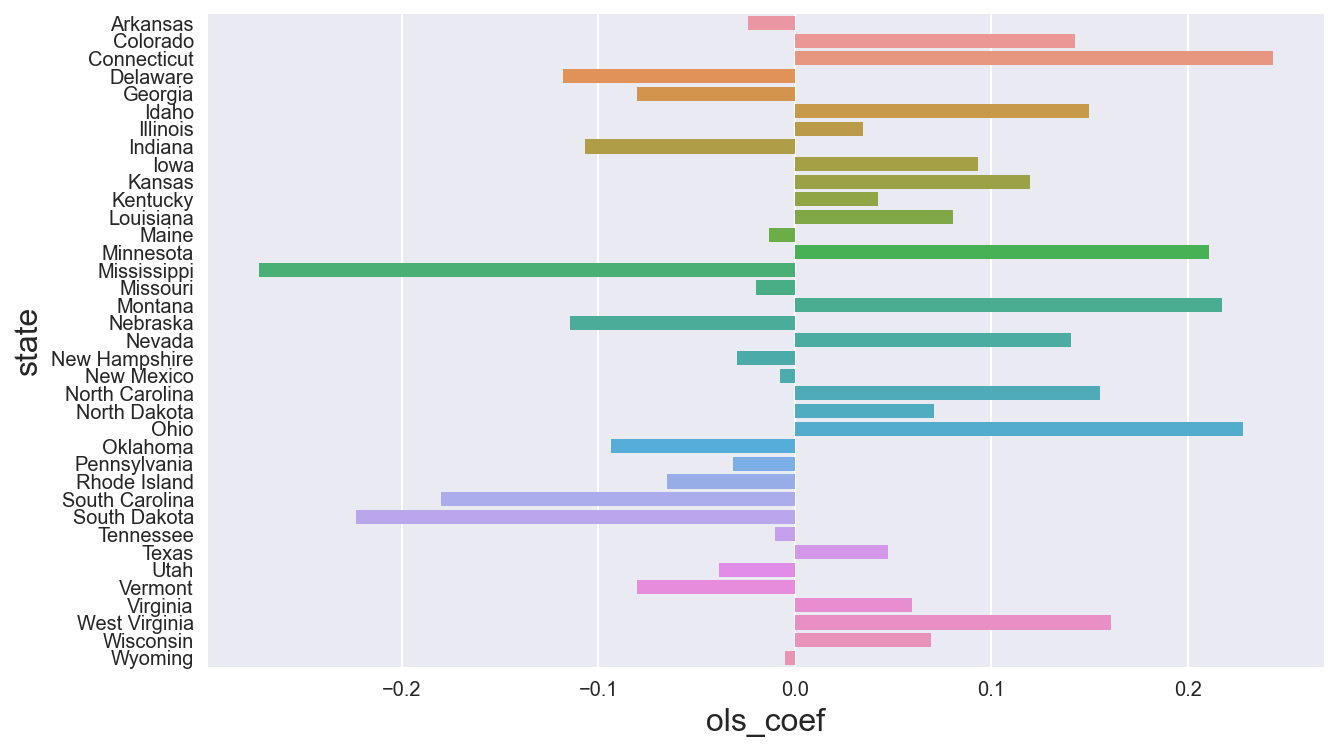

In [12]:
df_states = pd.DataFrame({'state': df.columns[[i for i in range(2,40) if i!=3]], 'ols_coef': coef[1:]})
sns.barplot(data=df_states, x='ols_coef', y='state');

We have many **negative weights**, which do not make much sense from a causal inference perspective. Since we would like to interpret our synthetic control as a **weighted average** of untreated states, all weights should be positive  and they should sum to one.  

To address both concerns, we are going to build a new estimator called `SyntheticControl()` which constrains the weights to be positive and to sum to one.

In [13]:
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp

class SyntheticControl():
    
    # Loss function
    def loss(self, W, X, y) -> float:
        return np.sqrt(np.mean((y - X.dot(W))**2))

    # Fit model
    def fit(self, X, y):
        w_start = [1/X.shape[1]]*X.shape[1]
        self.coef_ = fmin_slsqp(partial(self.loss, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
        self.mse = self.loss(W=self.coef_, X=X, y=y)
        return self
    
    # Predict 
    def predict(self, X):
        return X.dot(self.coef_)

We can now plot the actual and predicted cigarette sales in California using the `SyntheticControl` method.

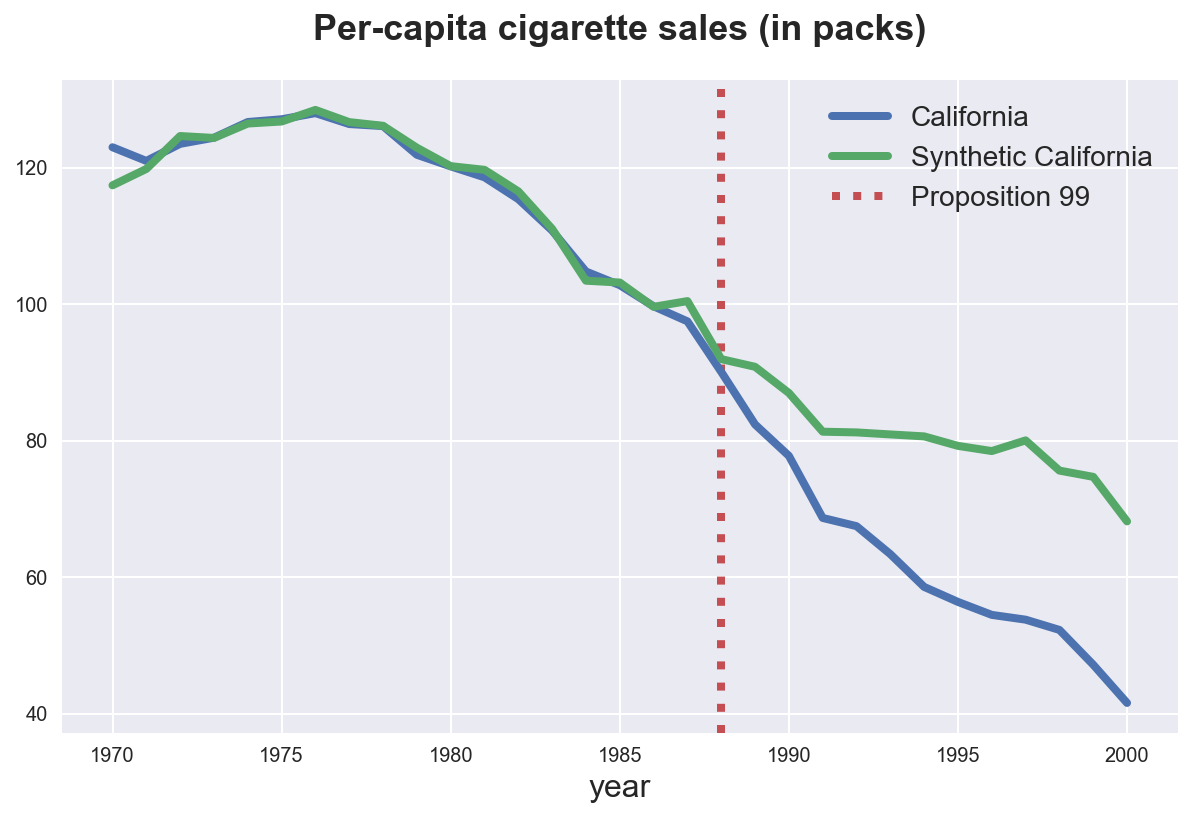

In [14]:
coef_new = synth_predict(df, 'California', SyntheticControl()).coef_
plot_lines(df, 'California', 'Synthetic California')

It looks like the effect is again negative. However, let's plot the **difference** between the two lines to better visualize the magnitude.

In [15]:
def plot_difference(df, state, vline=True, hline=True, **kwargs):
    sns.lineplot(x=df['year'], y=df[state] - df[f'Synthetic {state}'], **kwargs)
    if vline: 
        plt.axvline(x=1988, ls=":", color='C2', label='Proposition 99', zorder=1)
        plt.legend()
    if hline: sns.lineplot(x=df['year'], y=0, lw=1, color='black', zorder=1)
    plt.title("Normalized per-capita cigarette sales (in packs)");

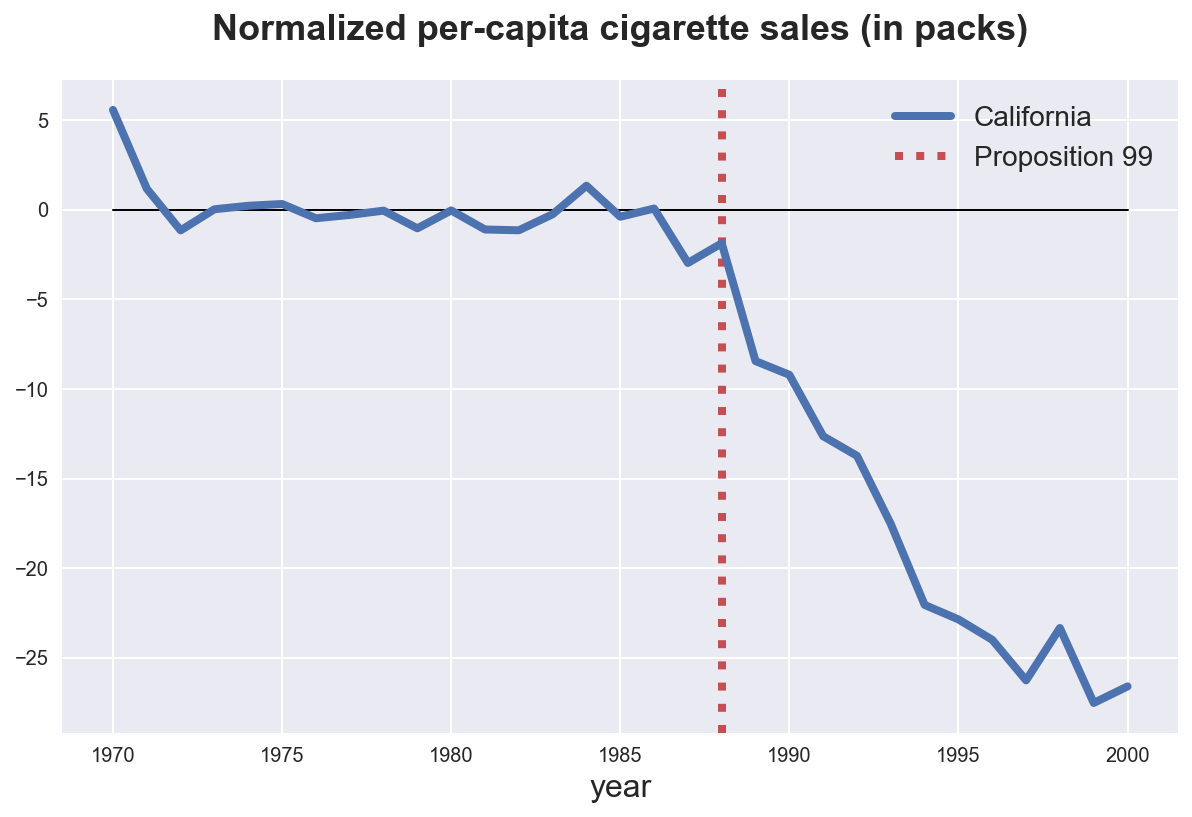

In [16]:
plot_difference(df, 'California', label='California')

The difference is clearly negative and decreasing over time. Moreover, now we see that the estimator is not overfitting the pre-period anymore. The reason is that the non-negativity constraint is constraining most coefficients to be zero (as [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) does).

We can visualize it by plotting the distribution of coefficients.

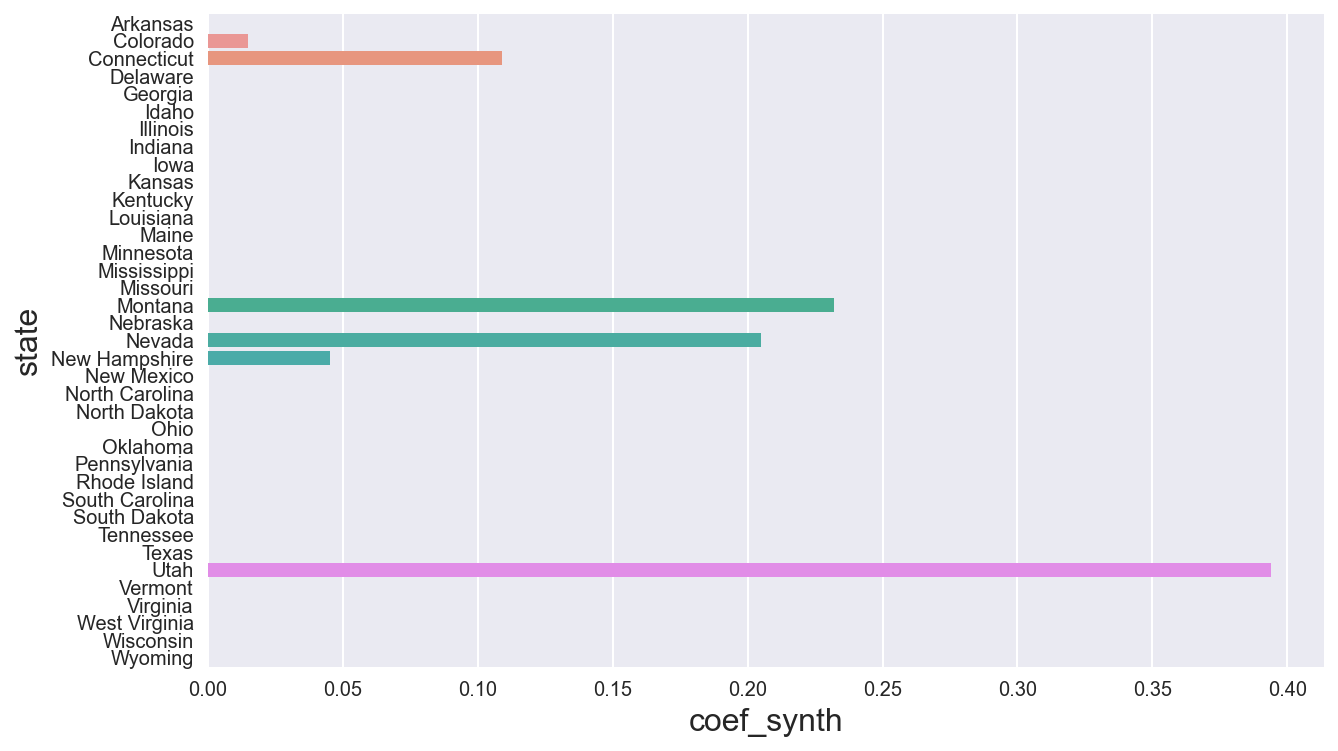

In [17]:
df_states['coef_synth'] = coef_new[1:]
sns.barplot(data=df_states, x='coef_synth', y='state');

What about **inference**? Is the estimate significantly different from zero? Or, more practically, "*how unusual is this estimate under the null hypothesis of no policy effect*?". 

We are going to perform a **randomization/permutation test** in order to answer this question. The **idea** is that if the policy has no effect, the effect we observe for California should not be significantly different from the effect we observe for any other state.

Therefore, we are going to replicate the procedure above, but for all other states and observe how unusual is California.

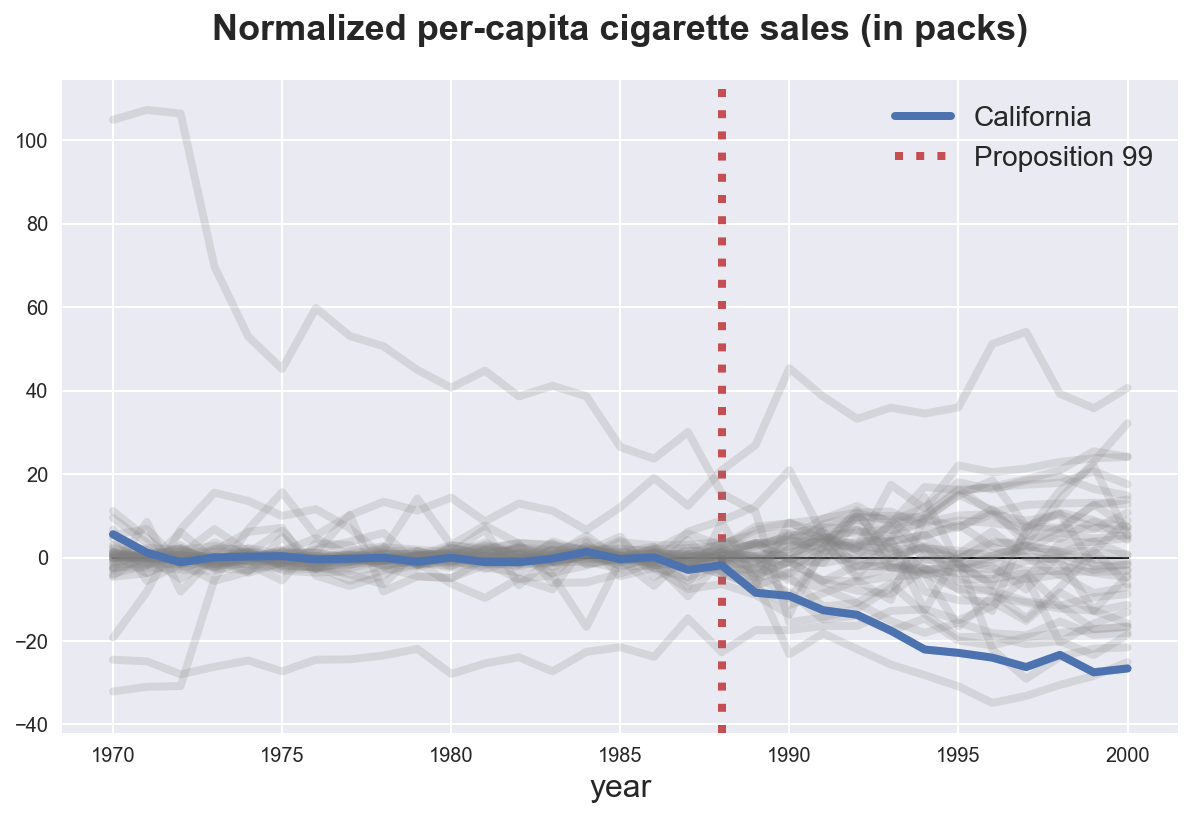

In [18]:
for state in states:
    synth_predict(df, state, SyntheticControl())
    plot_difference(df, state, vline=False, alpha=0.2, color='grey')
plot_difference(df, 'California', label='California')

From the graph we notice two things. First, the effect for California is quite extreme and therefore likely not to be driven by random noise. 

Second, we also notice that there are a couple of states for which we cannot fit the pre-trend very well. This is expected since, for each state, we are building the counterfactual trend as a **convex combination** of all other states. States that are quite extreme in terms of cigarette consumpion are very useful to build the counterfactuals of other states, but it's hard to build a counterfactual for them. Not to bias the analysis, let's exclude states for which we cannot build a "good enough" counterfectual, in terms of pre-treatment MSE.

$$
MSE_{pre} = \frac{1}{n} \sum_{t \in \text{pre}} \left( Y_t - \hat Y_t \right)^2 
$$

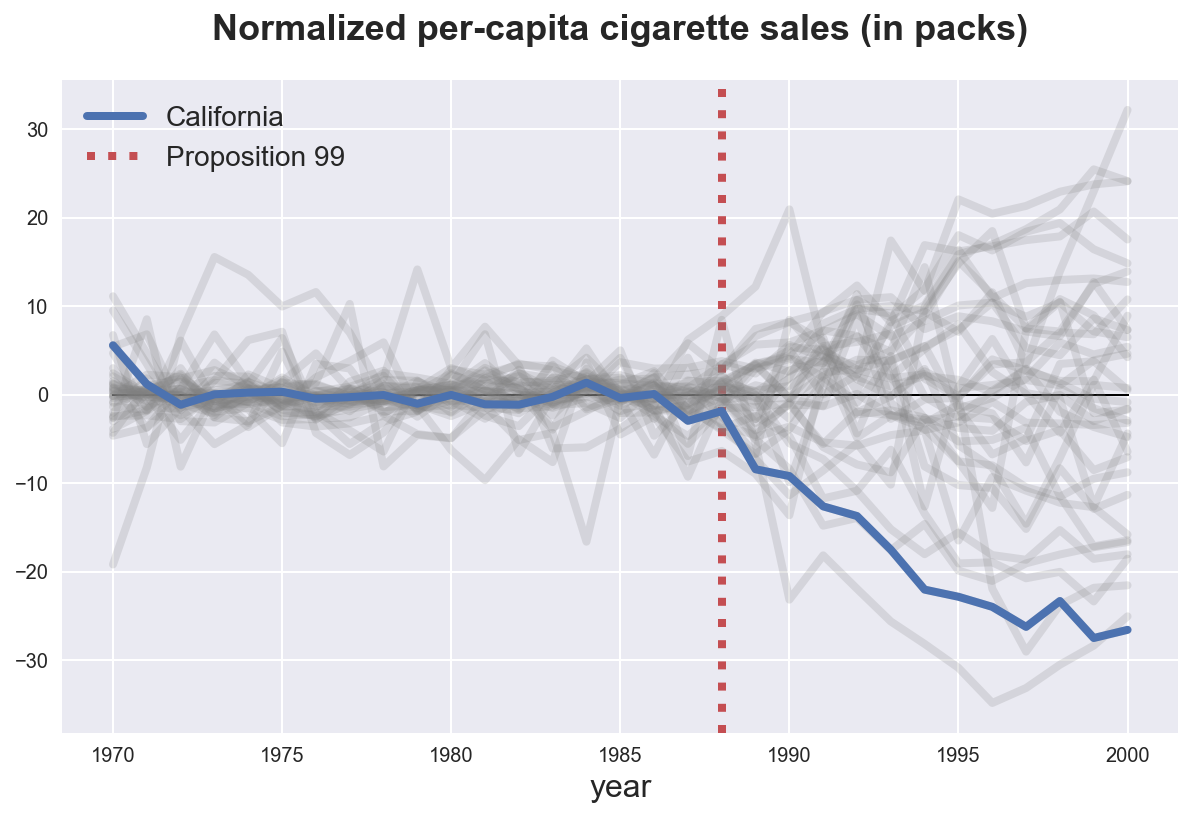

In [19]:
for state in states:
    mse = synth_predict(df, state, SyntheticControl()).mse
    if mse < 15:
        plot_difference(df, state, vline=False, alpha=0.2, color='grey')
plot_difference(df, 'California', label='California')

After exluding extreme observations, it looks like the effect for California is very unusual, especially if we consider a one-sided hypothesis test (it feels weird to assume that the policy could ever increase cigarette sales). 

One **statistic** that the authors suggest to perform a randomization test is the ratio between pre-treatment MSE and post-treatment MSE.

$$
\lambda = \frac{MSE_{post}}{MSE_{pre}} = \frac{\frac{1}{n} \sum_{t \in \text{post}} \left( Y_t - \hat Y_t \right)^2 }{\frac{1}{n} \sum_{t \in \text{pre}} \left( Y_t - \hat Y_t \right)^2 }
$$

We can compute a p-value as the number of observations with higher ratio.

In [20]:
lambdas = {}
for state in states:
    mse_pre = synth_predict(df, state, SyntheticControl()).mse
    mse_tot = np.mean((df[f'Synthetic {state}'] - df[state])**2)
    lambdas[state] = (mse_tot - mse_pre) / mse_pre
    
print(f"p-value: {np.mean(np.fromiter(lambdas.values(), dtype='float') > lambdas['California']):.4}")

p-value: 0.02564


It seems that only $2.5\%$ of the states had a larger MSE ratio. We can visualize the distribution of the statistic under permutation with a histogram.

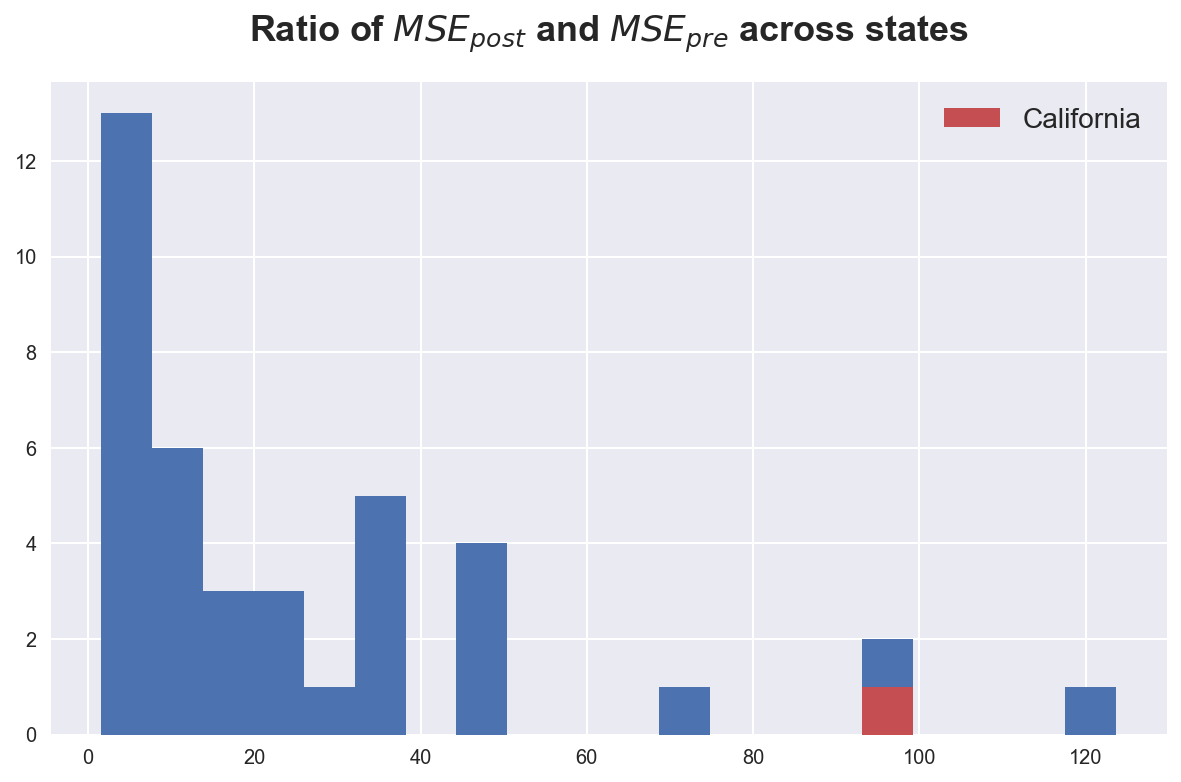

In [21]:
_, bins, _ = plt.hist(lambdas.values(), bins=20);
plt.hist([lambdas['California']], bins=bins, color="C2", label="California")
plt.legend();
plt.title('Ratio of $MSE_{post}$ and $MSE_{pre}$ across states');

Indeed, the California statistic is quite extreme.

## References

- [Video lecture on Synthetic Controls](https://www.youtube.com/watch?v=BsRqy7juMus) by Paul Goldsmith-Pinkham (Yale)
- [Chapter 10](https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html) of Causal Inference for the Brave and True by Matheus Facure
- [Chapter 15](https://mixtape.scunning.com/synthetic-control.html) of Causal Inference: The Mixtape by Scott Cunningham